#Setup and Data Preparation

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd

# 1) Read in each dataset
df_netflix = pd.read_csv("netflix_titles.csv")
df_amazon  = pd.read_csv("amazon_prime_titles.csv")
df_hulu    = pd.read_csv("hulu_titles.csv")
df_disney  = pd.read_csv("disney_plus_titles.csv")

# 2) Label each DataFrame with a 'service' column so we can combine them easily
df_netflix["service"] = "Netflix"
df_amazon["service"]  = "Amazon Prime"
df_hulu["service"]    = "Hulu"
df_disney["service"]  = "Disney+"

# 3) Concatenate into a single DataFrame
df_all = pd.concat([df_netflix, df_amazon, df_hulu, df_disney], ignore_index=True)

# Quick cleaning or sanity checks (optional):
# e.g., convert 'date_added' to datetime, handle missing values, etc.
df_all["date_added"] = pd.to_datetime(df_all["date_added"], errors="coerce")

#Bar Chart

<ipython-input-2-21ab4f0ee584>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


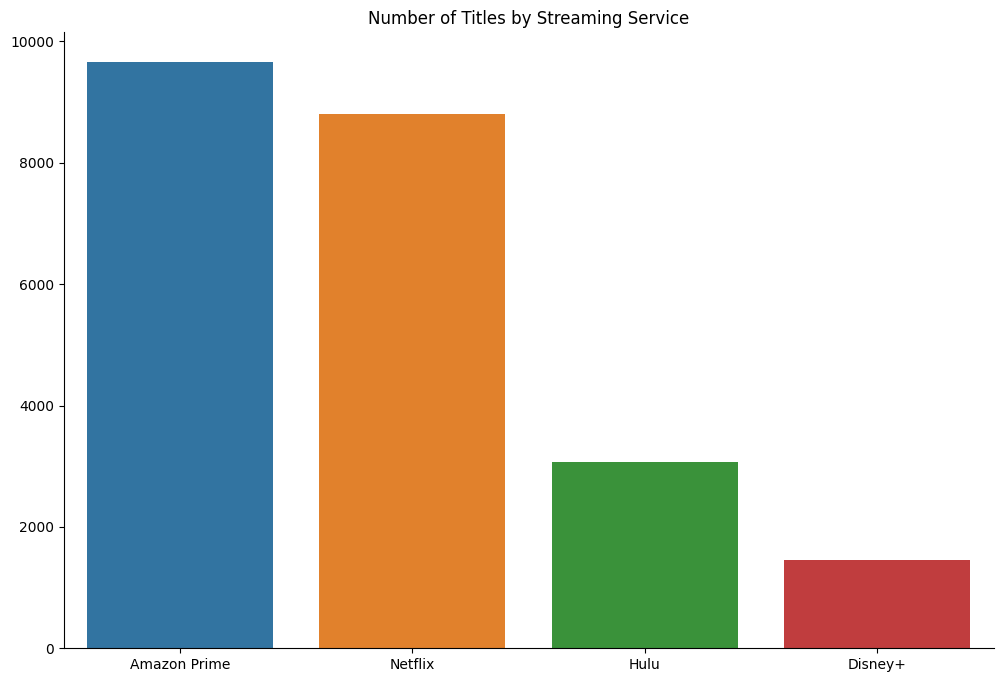

In [2]:
# Count occurrences of each service
service_counts = df_all["service"].value_counts()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=service_counts.index,
    y=service_counts.values,
    palette="tab10"
)

# Customize plot
sns.despine(right=True, top=True)  # Remove right and top spines
plt.xlabel("")  # Remove x-axis label
plt.ylabel("")
plt.title("Number of Titles by Streaming Service")

# Display the plot
plt.show()

#Line Chart

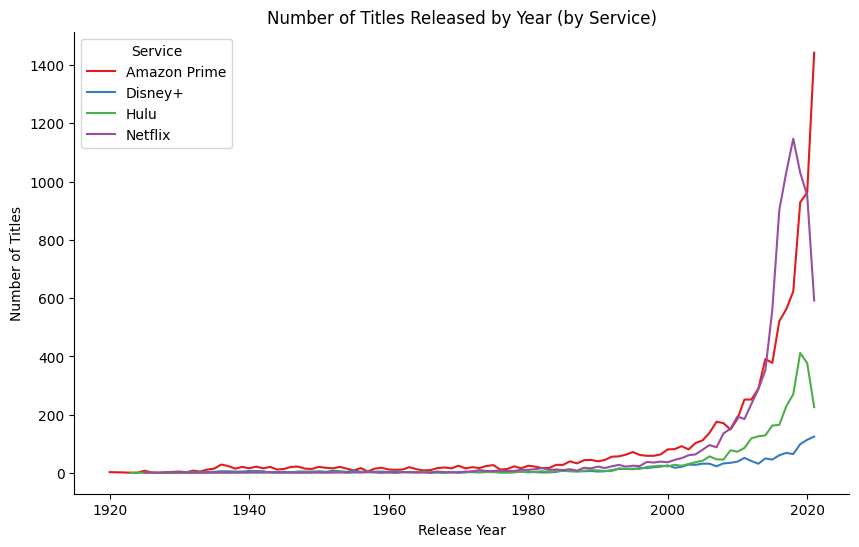

In [3]:
# Drop rows with missing 'release_year' just for clarity
df_year_service = df_all.dropna(subset=["release_year"])

# Group by 'service' and 'release_year', count how many titles
year_counts = df_year_service.groupby(["service", "release_year"])["title"].count().reset_index()
year_counts.rename(columns={"title":"count"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=year_counts,
    x="release_year",
    y="count",
    hue="service",
    palette="Set1"
)

sns.despine(right=True, top=True)

plt.title("Number of Titles Released by Year (by Service)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend(title="Service")
plt.show()

#Histogram (or Density Plot)

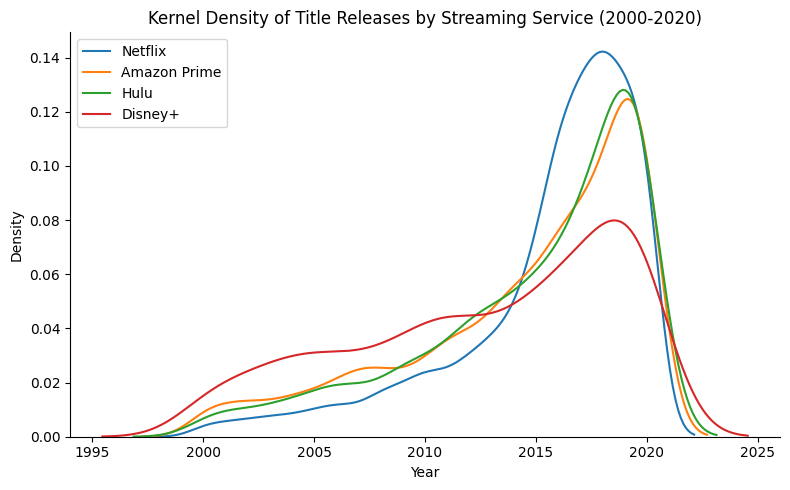

In [4]:
# Filter the data for release years between 2000 and 2020
filtered_df = df_year_service[
    (df_year_service["release_year"] >= 2000) & (df_year_service["release_year"] <= 2020)
]

# Create a figure
plt.figure(figsize=(8, 5))

# Plot a separate kernel density for each streaming service without shading
for service in filtered_df["service"].unique():
    subset = filtered_df[filtered_df["service"] == service]
    sns.kdeplot(
        data=subset,
        x="release_year",
        label=service,  # Each service gets a label in the legend
        fill=False      # No shaded area for a cleaner look
    )

sns.despine(right=True, top=True)

# Customize plot to match the style
plt.title("Kernel Density of Title Releases by Streaming Service (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Density")
plt.legend(title="", )

# Improve layout
plt.tight_layout()
plt.show()

#Scatter Plot

In [12]:
# 1) Drop rows with NaN in 'release_year' or 'duration'
df_all = df_all.dropna(subset=["release_year", "duration"]).copy()

# 2) Convert 'duration' to numeric minutes if possible
df_all.loc[:, "duration_minutes"] = (
    df_all["duration"]
    .str.replace(" min", "", regex=False)
    .str.replace("Season", "", regex=False)
    .str.replace("s", "", regex=False)  # remove trailing "s"
    .str.strip()
)

# 3) Keep only rows where duration_minutes is a valid digit
df_scatter = df_all[df_all["duration_minutes"].str.isdigit()].copy()
df_scatter.loc[:, "duration_minutes"] = df_scatter["duration_minutes"].astype(int)

# 4) OPTIONAL: Filter out extreme outliers (e.g. anything > 300 minutes)
df_scatter = df_scatter[df_scatter["duration_minutes"] <= 300]

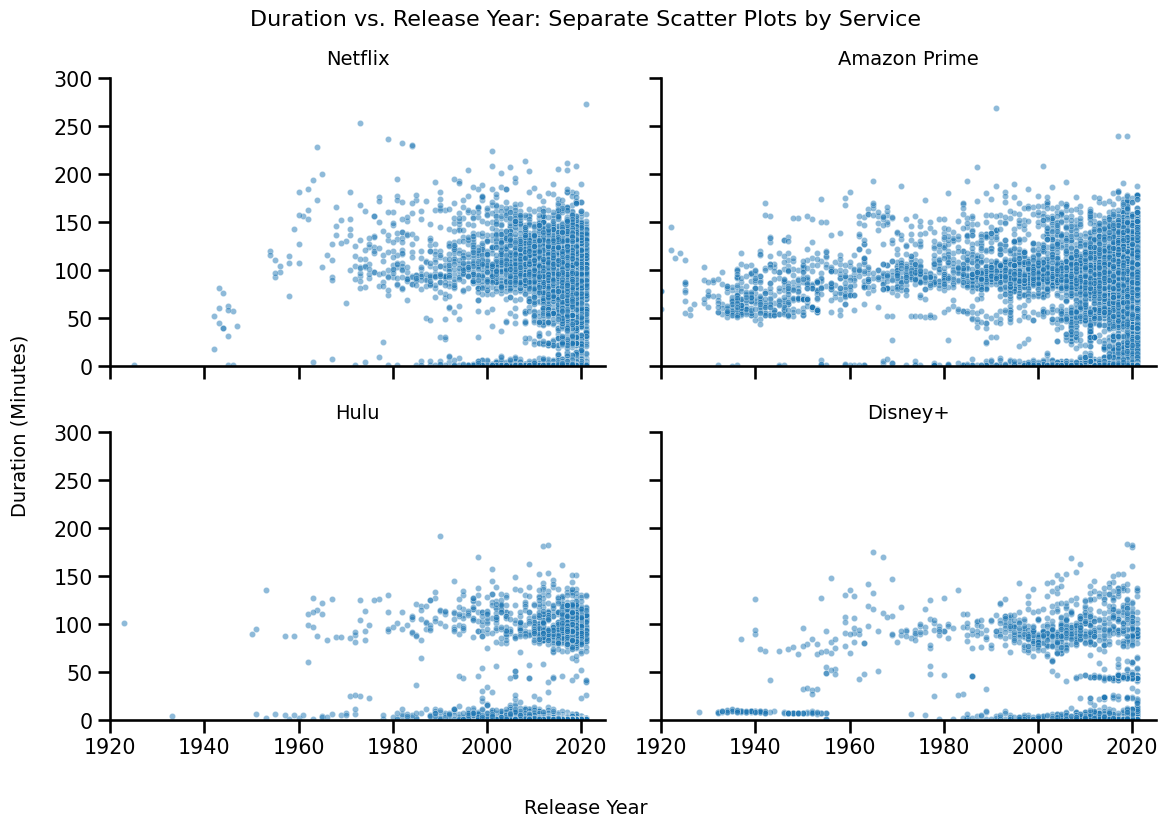

In [13]:
# 1) Set a clean style and context
sns.set_style()
sns.set_context("talk", font_scale=0.9)

# 2) Prepare subplots
services = ["Netflix", "Amazon Prime", "Hulu", "Disney+"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# 3) Create one scatter plot per service
for ax, service in zip(axes, services):
    subset = df_scatter[df_scatter["service"] == service]

    sns.scatterplot(
        data=subset,
        x="release_year",
        y="duration_minutes",
        s=20,        # smaller marker size
        alpha=0.5,   # slight transparency
        color="#1f77b4",
        ax=ax
    )

    # Set subplot title
    ax.set_title(service, fontsize=14, pad=10)

    # Remove individual x and y labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    # (Optional) Adjust x/y limits for a cleaner view
    ax.set_xlim(1920, 2025)  # or whatever range makes sense for your data
    ax.set_ylim(0, 300)      # matches our outlier filter

# 4) Add overall axis labels
fig.supxlabel("Release Year", fontsize=14)
fig.supylabel("Duration (Minutes)", fontsize=14)

# 5) Improve spacing and overall title
plt.tight_layout()
fig.suptitle("Duration vs. Release Year: Separate Scatter Plots by Service", fontsize=16, y=1.02)

# 6) Remove top and right spines for a cleaner look
sns.despine()

plt.show()

#Pie Chart

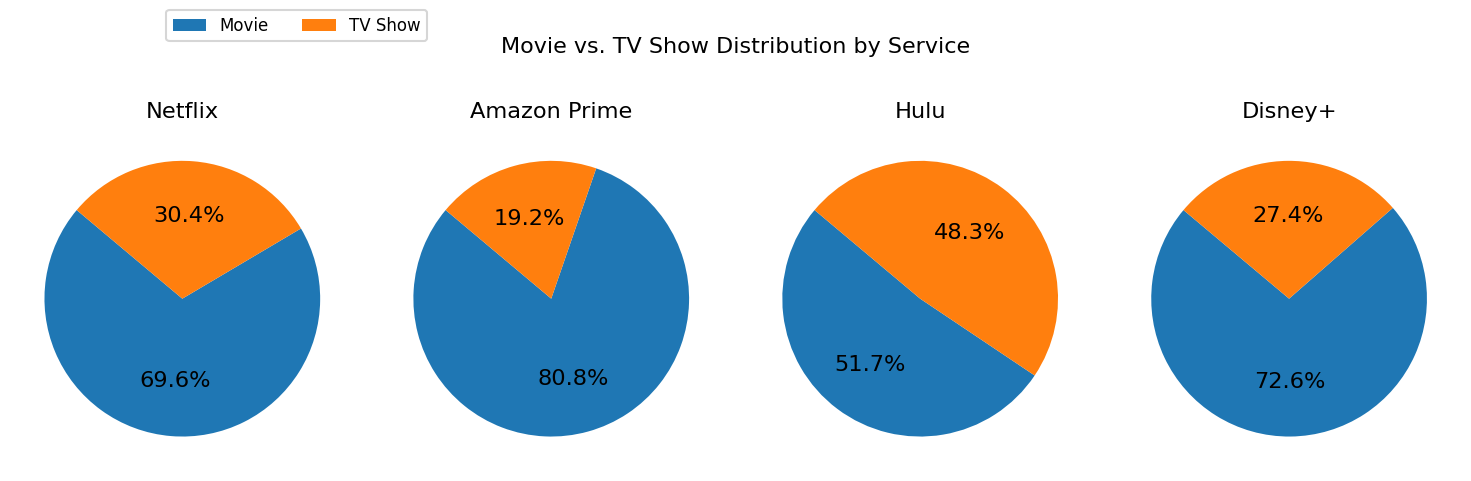

In [27]:
# 1) Get unique services
services = df_all["service"].unique()

# 2) Create subplots
fig, axes = plt.subplots(1, len(services), figsize=(15, 5))

# 3) Define colors for consistency
colors = ["#1f77b4", "#ff7f0e"]  # Blue for Movies, Orange for TV Shows
labels = ["Movie", "TV Show"]

# 4) Generate pie charts for each service
for ax, service in zip(axes, services):
    data_subset = df_all[df_all["service"] == service]
    type_counts = data_subset["type"].value_counts()

    ax.pie(
        type_counts.values,
        autopct="%1.1f%%",
        startangle=140,
        colors=colors  # Ensure consistent coloring
    )
    ax.set_title(f"{service}")

# 5) Add a single legend outside the subplots
fig.legend(labels, loc="upper right", bbox_to_anchor=(0.3, 1.05), ncol=2, fontsize=12)

# 6) Improve layout and display
plt.suptitle("Movie vs. TV Show Distribution by Service", fontsize=16)
plt.tight_layout()
plt.show()

# Stacked Bar Chart

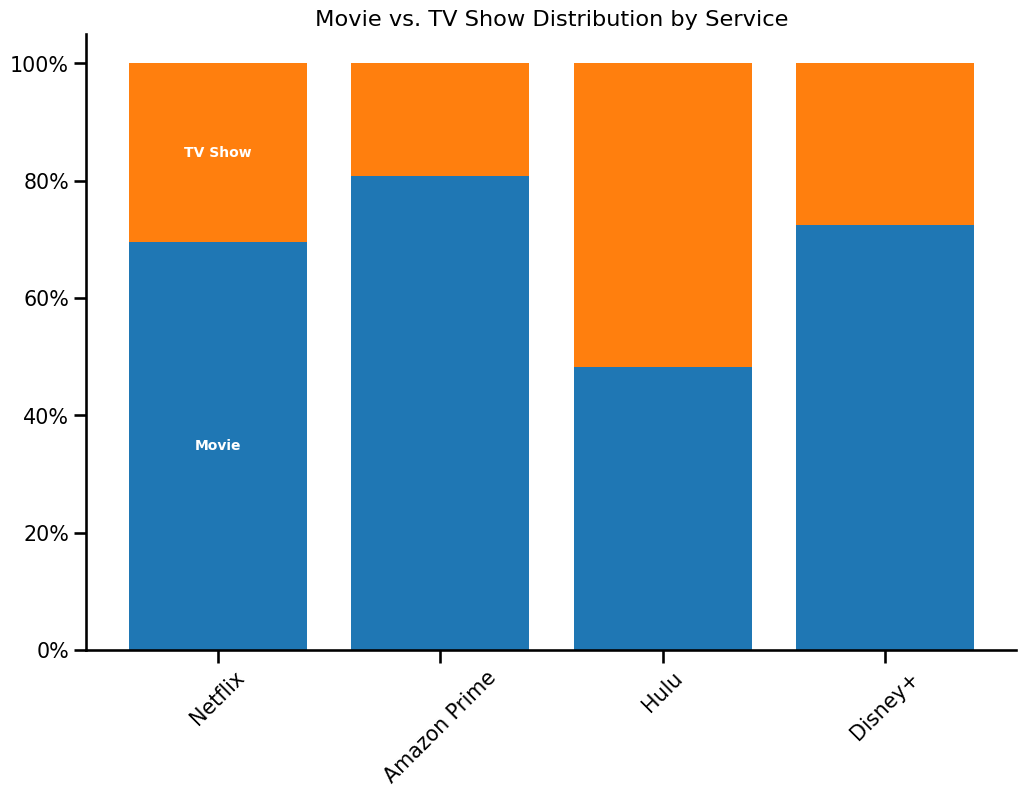

In [17]:
# Prepare the data for a 100% stacked bar chart
services = df_all["service"].unique()
type_distribution = {}

# Calculate the proportion of each type for every service
for service in services:
    data_subset = df_all[df_all["service"] == service]
    type_counts = data_subset["type"].value_counts(normalize=True)  # Normalize for percentages
    type_distribution[service] = type_counts

# Convert the data into a DataFrame for easier plotting
type_distribution_df = pd.DataFrame(type_distribution).fillna(0).T  # Transpose and fill missing values

# Plot the 100% stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for consistency
colors = sns.color_palette("tab10")
bar_positions = range(len(type_distribution_df))

# Plot the stacked bars with annotations inside the first bar
bottoms = [0] * len(type_distribution_df)
for i, column in enumerate(type_distribution_df.columns):
    bars = ax.bar(
        bar_positions,
        type_distribution_df[column],
        bottom=bottoms,
        color=colors[i],
        label=column
    )

    # Add text labels inside the first bar for clarity
    for j, bar in enumerate(bars):
        if j == 0:  # Only label inside the first bar
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bottoms[j] + height / 2,
                    f"{column}",
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=10,
                    fontweight='bold'
                )
    bottoms = [sum(x) for x in zip(bottoms, type_distribution_df[column])]

# Customize the plot
ax.set_title("Movie vs. TV Show Distribution by Service")
ax.set_ylabel("")
ax.set_xticks(bar_positions)
ax.set_xticklabels(type_distribution_df.index, rotation=45)
ax.set_xlabel("")  # Remove x-axis label

# Format y-axis to show percentage signs
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 means values are between 0 and 1

# Remove unnecessary spines and legend
sns.despine(top=True, right=True)
ax.legend().remove()

plt.show()